In [1]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 20
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [2]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_localization_matrix(n, radius)
    pred_states, pred_covariances, states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    ensemble_mean_pred = jnp.mean(pred_states, axis=-1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean_pred, pred_covariances, ensemble_mean, covariances, n, l96_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost

In [3]:
inflation = 1.5  # Fixed starting value for inflation
radius_opt = 1.0
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_localization_matrix(n, radius_opt)



In [4]:
key, subkey = random.split(key)
var_cost(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

Array(13597.86862919, dtype=float64)

In [5]:
print(jax.value_and_grad(var_cost) (radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

(Array(13597.86862919, dtype=float64), Array(-1120.10984332, dtype=float64))


In [6]:
ensemble_init.shape

(40, 20)

In [7]:
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
!pip install optax

In [8]:
import jax
import jax.numpy as jnp
from jax import grad, random
import optax
from IPython.display import clear_output
from tqdm.notebook import tqdm
import properscoring

var_cost_grad = grad(var_cost, argnums=(0, 1))

optimizer_radius = optax.adam(learning_rate=1e-5)
optimizer_inflation = optax.adam(learning_rate=1e-7)


params = {'radius': 20.0, 'inflation': 1.5}
param_labels = {
    'radius': 'radius',
    'inflation': 'inflation'
}
optimizer = optax.multi_transform({
    'radius': optimizer_radius,
    'inflation': optimizer_inflation
}, param_labels)

opt_state = optimizer.init(params)

key = random.PRNGKey(0)
N = 10  # number of Monte Carlo samples
m0 = initial_state  # initial state
C0 = Q  # initial covariance

ensemble_init = random.multivariate_normal(key, m0, C0, (n_ensemble,)).T

crpss = []
radii = []
inflations = []
rmses = []
true_div = []

for _ in tqdm(range(100)):
    key, subkey = random.split(key)
    # calculate gradients for both parameters
    gradients = var_cost_grad(params['radius'], params['inflation'], l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    updates, opt_state = optimizer.update({'radius': gradients[0], 'inflation': gradients[1]}, opt_state)
    updates['radius'] = jnp.clip(updates['radius'], -1, 1)
    updates['inflation'] = jnp.clip(updates['inflation'], -0.1, 0.1)
    params = optax.apply_updates(params, updates)
    

    params['radius'] = jnp.clip(params['radius'], 1, 40)
    params['inflation'] = jnp.clip(params['inflation'], 1, 2)

    radii.append(params['radius'])
    inflations.append(params['inflation'])

    localization_matrix = generate_localization_matrix(n, params['radius'])
    pred_states, pred_covars, states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, params['inflation'], key)

    ensemble_mean = jnp.mean(states, axis=-1)
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)

    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)

    total_kl_divergence = jnp.sum(jnp.array([KL_gaussian(n, ensemble_mean[t], covariances[t], base_m[t], base_C[t]) for t in range(num_steps)])) / num_steps
    true_div.append(total_kl_divergence)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# import properscoring
# from IPython.display import clear_output
# from jax import grad
# from tqdm.notebook import tqdm
# import jax.numpy as jnp
# from jax import random


# var_cost_grad = grad(var_cost, argnums=(0,1))

# inflation_opt = 1.05  # Starting value for inflation
# radius_opt = 16.0
# alpha_radius = 1e-5  # Learning rate for radius
# alpha_inflation = 1e-7   # Learning rate for inflation

# key = random.PRNGKey(0)  # Random key
# N = 10  # Number of MC samples
# m0 = initial_state
# C0 = Q  # Initial covariance, assuming Q is your process noise covariance
# ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

# crpss = []
# radii = []
# inflations = []
# rmses=[]
# true_div = []


# for i in tqdm(range(100)):
#     key, subkey = random.split(key)
#     grad_radius, grad_inflation = var_cost_grad(radius_opt, inflation_opt, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
#     radius_opt -= alpha_radius * grad_radius  # Update radius
#     inflation_opt -= alpha_inflation * grad_inflation  # Update inflation
#     radius_opt = jnp.clip(radius_opt, 1, 40)
#     inflation_opt = jnp.clip(inflation_opt, 1, 2)
#     localization_matrix = generate_localization_matrix(n, radius_opt)
#     radii.append(radius_opt)
#     inflations.append(inflation_opt)

#     states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
#     ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
#     rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
#     # print(radius_opt, grad_radius, rmse)
#     # print(inflation_opt, grad_inflation, rmse)

#     rmses.append(rmse)
#     crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
#     crpss.append(crps)
#     total_kl_divergence = 0
#     for t in range(num_steps):  
#         kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
#         total_kl_divergence += kl_div_t 
#     true_div.append(total_kl_divergence / num_steps)
    

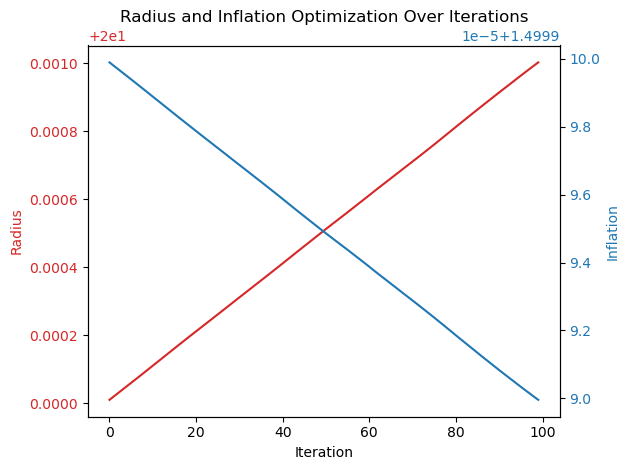

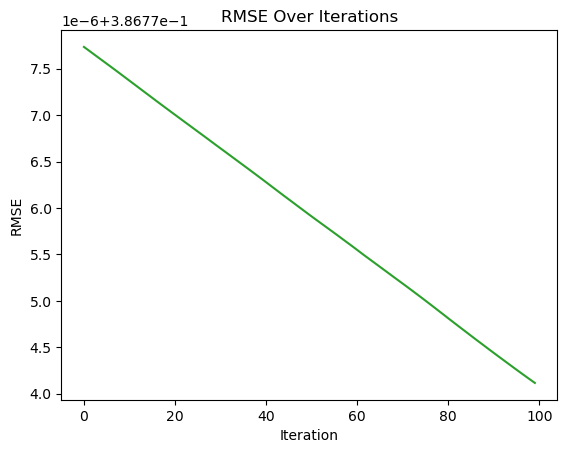

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Radius', color=color)
ax1.plot(radii, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)  
ax2.plot(inflations, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Radius and Inflation Optimization Over Iterations')
fig.tight_layout()  

plt.figure() 
plt.plot(rmses, color='tab:green')
plt.title('RMSE Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jax import jit



radius_values = np.linspace(1, 40, 50)
inflation_values = np.linspace(1, 2, 50)
radius_grid, inflation_grid = np.meshgrid(radius_values, inflation_values)

@jit
def evaluate_cost(radius, inflation):
    return var_cost(radius, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

cost_values = np.vectorize(evaluate_cost)(radius_grid, inflation_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.contour3D(radius_grid, inflation_grid, cost_values, 50, cmap='binary')
ax.plot(radii, inflations, rmses, 'r-', label='Descent Path')  # rmses as z-axis values

ax.set_xlabel('Radius')
ax.set_ylabel('Inflation')
ax.set_zlabel('Cost')
ax.set_title('3D Contour Plot of Optimization')
ax.legend()

plt.show()
